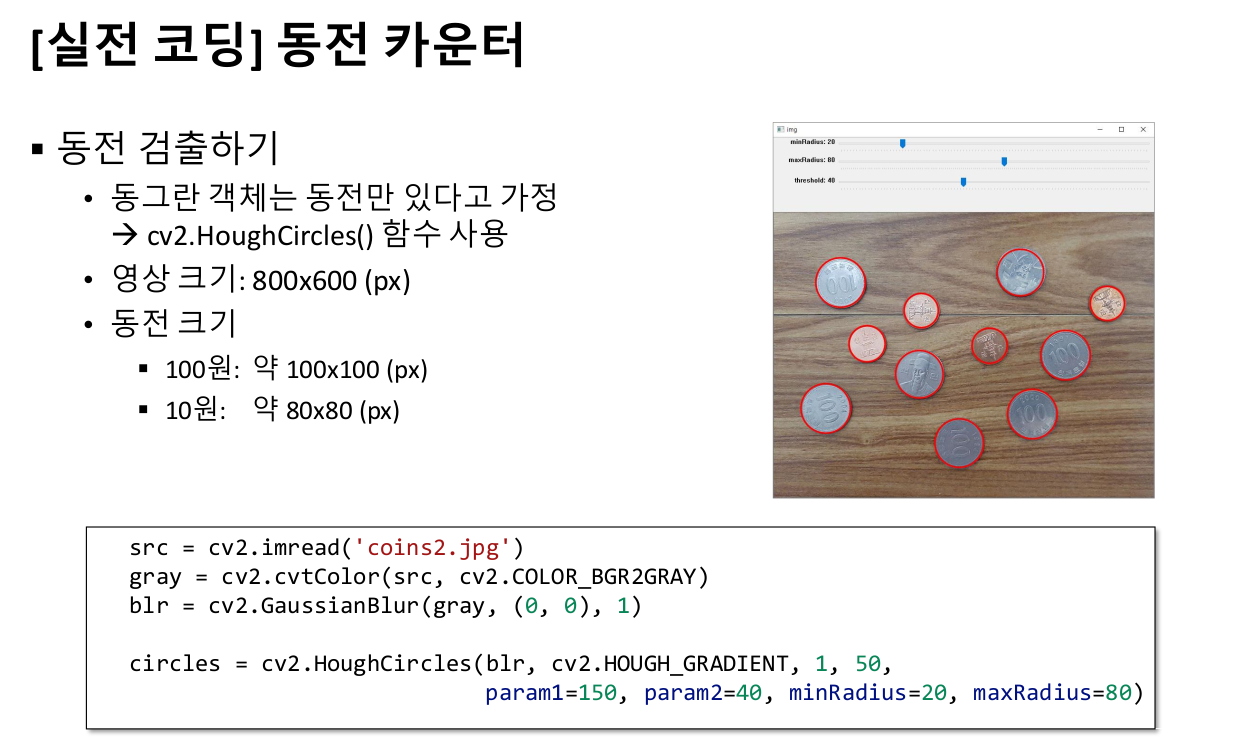

In [2]:
import sys
import numpy as np
import cv2


# 입력 이미지 불러오기
src = cv2.imread('../data/coins1.jpg')

if src is None:
    print('Image open failed!')
    sys.exit()

gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
blr = cv2.GaussianBlur(gray, (0, 0), 1)

# 허프 변환 원 검출
circles = cv2.HoughCircles(blr, cv2.HOUGH_GRADIENT, 1, 50,
                           param1=150, param2=40, minRadius=20, maxRadius=80)

# 원 검출 결과 및 동전 금액 출력
sum_of_money = 0
dst = src.copy()
if circles is not None:
    for i in range(circles.shape[1]):
        cx, cy, radius = circles[0][i]
        cv2.circle(dst, (cx, cy), radius, (0, 0, 255), 2, cv2.LINE_AA)

        # 동전 영역 부분 영상 추출
        x1 = int(cx - radius)
        y1 = int(cy - radius)
        x2 = int(cx + radius)
        y2 = int(cy + radius)
        radius = int(radius)
        
        crop = dst[y1:y2, x1:x2, :]
        ch, cw = crop.shape[:2]

        # 동전 영역에 대한 ROI 마스크 영상 생성
        mask = np.zeros((ch, cw), np.uint8)
        cv2.circle(mask, (cw//2, ch//2), radius, 255, -1)

        # 동전 영역 Hue 색 성분을 +40 시프트하고, Hue 평균을 계산
        hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
        hue, _, _ = cv2.split(hsv)
        hue_shift = (hue + 40) % 180
        mean_of_hue = cv2.mean(hue_shift, mask)[0]

        # Hue 평균이 90보다 작으면 10원, 90보다 크면 100원으로 간주
        won = 100
        if mean_of_hue < 90:
            won = 10

        sum_of_money += won

        cv2.putText(crop, str(won), (20, 50), cv2.FONT_HERSHEY_SIMPLEX,
                    0.75, (255, 0, 0), 2, cv2.LINE_AA)

cv2.putText(dst, str(sum_of_money) + ' won', (40, 80),
            cv2.FONT_HERSHEY_DUPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)

cv2.imshow('src', src)
cv2.imshow('dst', dst)
cv2.waitKey()

cv2.destroyAllWindows()
